### Customer churn analysis
This notebook analyses a dataset containing insurance customer data and whether the given customers canceled contracts with the insurance company. As the task was given to me while applying for a Data Science role for a company, the file itself is under an NDA and, unfortunately, I cannot share it here. However, the rest of the notebook shows the use of scikit-learn pipelines and inclues some practical graphs that can be used to gain more insight into the dataset at hand.

##### Notes
This environment uses a nightly build of scikit-learn because the latest release does not include SimpleImputer.get_feature_names_out(), which is needed to get a dataframe back from a pipeline

##### Run
- `pipenv install`
- `pipenv shell`
    - `pip install --pre --extra-index https://pypi.anaconda.org/scipy-wheels-nightly/simple scikit-learn` (see https://scikit-learn.org/stable/developers/advanced_installation.html#installing-nightly-builds)
- `pipenv run jupyter notebook`

##### TODO
- complete integration of MLFlow


### 1. Importing and defining custom transformers and other methods

In [1]:
import os
import warnings
import sys
from datetime import date, datetime
from collections import Counter
from time import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.base import BaseEstimator, TransformerMixin, _OneToOneFeatureMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.pipeline import FeatureUnion, make_union
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import FunctionTransformer

from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, make_scorer, confusion_matrix, ConfusionMatrixDisplay

from sklearn.inspection import permutation_importance

# PandasFeatureUnion
from joblib import Parallel, delayed
from sklearn.pipeline import FeatureUnion, _fit_transform_one, _transform_one, _name_estimators
from scipy import sparse

from sklearn import set_config
set_config(display='diagram')
#set_config(display='text')

pd.set_option('display.max_rows', 300)


In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
def load_data():
    global X, y, X_train, X_validate, y_train, y_validate, df
    df = pd.read_csv("churn.csv", sep=";")

    X = df.drop("churn", axis=1)
    y = df[["churn"]]

    X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.2)
    print("Data loaded")
load_data()

pipeline_verbose = False

Data loaded


In [3]:
class ColumnDropperTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def transform(self, X, y=None):
        X_copy = X.copy()
        return X_copy.drop(self.columns, axis=1)

    def fit(self, X, y=None):
        return self
    
    def __str__(self):
        return f"Dropper:{len(self.columns)}:{str(self.columns)}"
    def __repr__(self):
        return f"Dropper:{len(self.columns)}:{str(self.columns)}"

class CreditScoreTransformer(BaseEstimator, TransformerMixin, _OneToOneFeatureMixin):
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_copy['credit_score'] = X_copy['credit_score'].apply(lambda s: s.replace("CreditScore: ", ""))
        X_copy['credit_score'] = X_copy['credit_score'].apply(pd.to_numeric)
        return X_copy

    def fit(self, X, y=None):
        return self 

class SalaryEstimatedTransformer(BaseEstimator, TransformerMixin, _OneToOneFeatureMixin):
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_copy["salary_estimated"] = pd.to_numeric(X_copy["salary_estimated"], errors='coerce')
        return X_copy

    def fit(self, X, y=None):
        return self 

class MonthlyFeesTransformer(BaseEstimator, TransformerMixin, _OneToOneFeatureMixin):
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_copy["monthly_fees"] = X_copy["monthly_fees"].str.replace(',', '.').apply(pd.to_numeric)
        return X_copy

    def fit(self, X, y=None):
        return self 

class HasHealthInsuranceTransformer(BaseEstimator, TransformerMixin, _OneToOneFeatureMixin):
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_copy['has_health_insurance'] = X_copy['has_health_insurance'].apply(lambda s: 1 if s == "YES" else s)
        X_copy['has_health_insurance'] = X_copy['has_health_insurance'].apply(pd.to_numeric)
        return X_copy

    def fit(self, X, y=None):
        return self 

class AgeTransformer(BaseEstimator, TransformerMixin):
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_copy['birthdate'] = pd.to_datetime(df['birthdate'], format="%d.%m.%Y")
        cur_year = datetime.now().year
        X_copy['age'] = X_copy['birthdate'].apply(lambda x : (cur_year - x.year))
        return X_copy

    def fit(self, X, y=None):
        return self
    
class PandasFeatureUnion(FeatureUnion):
    def fit_transform(self, X, y=None, **fit_params):
        self._validate_transformers()
        result = Parallel(n_jobs=self.n_jobs)(
            delayed(_fit_transform_one)(
                transformer=trans,
                X=X,
                y=y,
                weight=weight,
                **fit_params)
            for name, trans, weight in self._iter())

        if not result:
            # All transformers are None
            return np.zeros((X.shape[0], 0))
        Xs, transformers = zip(*result)
        self._update_transformer_list(transformers)
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs

    def merge_dataframes_by_column(self, Xs):
        return pd.concat(Xs, axis="columns", copy=False)

    def transform(self, X):
        Xs = Parallel(n_jobs=self.n_jobs)(
            delayed(_transform_one)(
                transformer=trans,
                X=X,
                y=None,
                weight=weight)
            for name, trans, weight in self._iter())
        if not Xs:
            # All transformers are None
            return np.zeros((X.shape[0], 0))
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs
    
    def make_union_pandas(*transformers, n_jobs=None, verbose=False):
        return PandasFeatureUnion(_name_estimators(transformers), n_jobs=n_jobs, verbose=verbose)
    
def filter_gridsearch_result(df):
    cols_to_display = [col_name for col_name in res_df.columns if not (
                        col_name.startswith("split") 
                        or col_name.startswith("std") 
                        or col_name.startswith("rank")
                        or "time" in col_name)
                      ]
    return res_df[cols_to_display]

def get_filename_from_params(params):
    l = [str(p["classify"][0])[:3] for p in params]
    return "-".join(l)


### 2. Preparing features and pipelines

In [4]:
numeric_features = ['account_balance', 'number_of_products', 'salary_estimated', 'monthly_fees', 'tenure']
categorical_features = ['country', 'sex']
binary_features = ['has_health_insurance','has_life_insurance']
columns_to_drop = ["row_number", "customer_id", "age", "birthdate", "credit_score"]


numeric_transformer = Pipeline(steps=[
     ('imputer', SimpleImputer(strategy='mean')),
     ('scaler', StandardScaler()),
])

categorical_transformer = Pipeline(steps=[ 
     ('imputer', SimpleImputer(strategy='most_frequent')),
     ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

binary_transformer = Pipeline(steps=[
     ('imputer', SimpleImputer(strategy='constant',fill_value=0))
])

column_transformer_preprocess = ColumnTransformer(
     transformers=[
          ('numeric', numeric_transformer, numeric_features),
          ('categorical', categorical_transformer, categorical_features),
          ('binary', binary_transformer, binary_features),
     ], remainder='drop')

dummy_classifier = SVC()
dummy_kbest = SelectKBest(mutual_info_classif, k=5)

pipe_clean = Pipeline(steps= [
    ("clean_salary_estimated", SalaryEstimatedTransformer()),
    ("clean_monthly_fees", MonthlyFeesTransformer()),
    ("clean_credit_score_transformer", CreditScoreTransformer()),
    ("clean_has_health_insurance", HasHealthInsuranceTransformer()),
    ("add_age_transformer", AgeTransformer()),
    ('drop', ColumnDropperTransformer(columns_to_drop)),
], verbose=pipeline_verbose)

pipe_prepro = Pipeline(steps= [
    ('clean', pipe_clean),
    ('preprocess', column_transformer_preprocess),
], verbose=pipeline_verbose)

pipe_all = Pipeline(steps= [
    ('clean', pipe_clean),
    ('preprocess', column_transformer_preprocess),
    ('select_features', dummy_kbest),
    ('classify', dummy_classifier)
], verbose=pipeline_verbose)

# excludes clean step to not do it everytime in GridSearch
pipe_process = Pipeline(steps= [
    ('preprocess', column_transformer_preprocess),
    ('select_features', dummy_kbest),
    ('classify', dummy_classifier)
], verbose=pipeline_verbose)


### 3. Run pipelines 

In [5]:
X_clean = pipe_clean.fit_transform(X)

X_prepro = pipe_prepro.fit_transform(X)
# following line only works with the nightly build of scikit-learn (.get_feature_names_out() not in latest release)
X_prepro_df = pd.DataFrame(X_prepro, columns=column_transformer_preprocess.get_feature_names_out())
X_prepro_df

,numeric__account_balance,numeric__number_of_products,numeric__salary_estimated,numeric__monthly_fees,numeric__tenure,categorical__country_France,categorical__country_Germany,categorical__country_Spain,categorical__sex_Female,categorical__sex_Male,binary__has_health_insurance,binary__has_life_insurance
0,-1.225848,-0.911583,0.021716,1.334867,-1.041760,1.0,0.0,0.0,1.0,0.0,1.0,1.0
1,0.117350,-0.911583,0.216392,1.555669,-1.387538,0.0,0.0,1.0,1.0,0.0,0.0,1.0
2,1.333053,2.527057,0.240549,-1.696106,1.032908,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,-1.225848,0.807737,-0.109108,1.639111,-1.387538,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.785728,-0.911583,-0.365505,1.401445,-1.041760,0.0,0.0,1.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-1.225848,0.807737,-0.066603,0.687136,-0.004426,1.0,0.0,0.0,0.0,1.0,1.0,0.0
9996,-0.306379,-0.911583,0.027818,0.889334,1.724464,1.0,0.0,0.0,0.0,1.0,1.0,1.0
9997,-1.225848,-0.911583,-1.008970,-0.022605,0.687130,1.0,0.0,0.0,1.0,0.0,0.0,1.0
9998,-0.022608,0.807737,-0.125424,0.085409,-0.695982,0.0,1.0,0.0,0.0,1.0,1.0,0.0


### 4. Let's have a look at some graphs to get some insights into the data set

Data loaded
churn_ratio: 0.2037


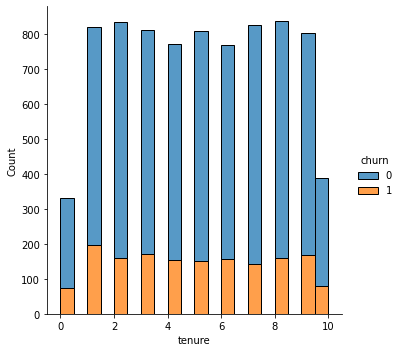

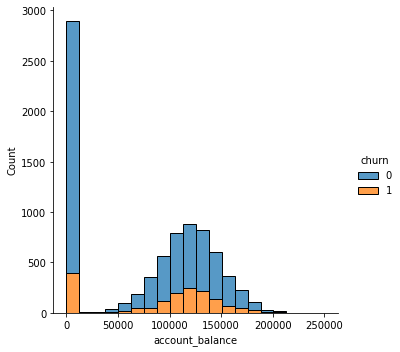

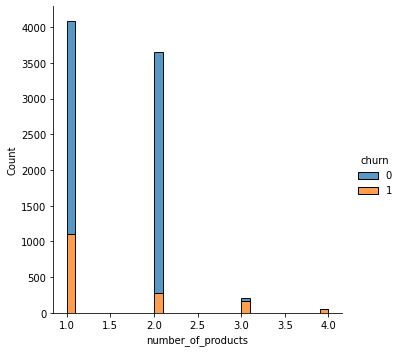

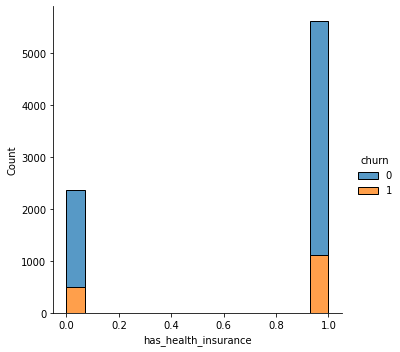

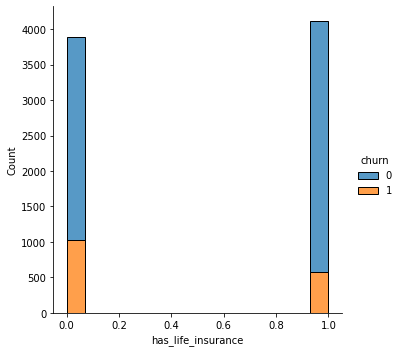

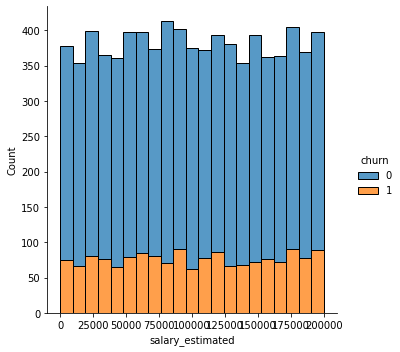

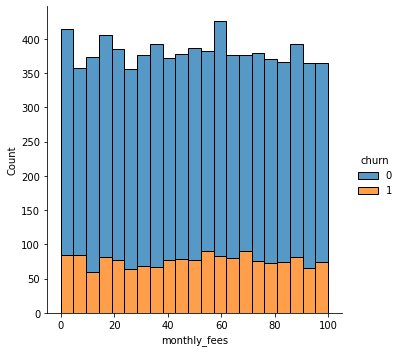

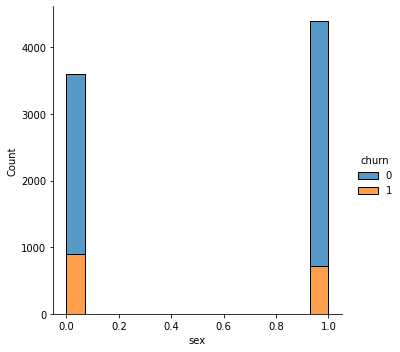

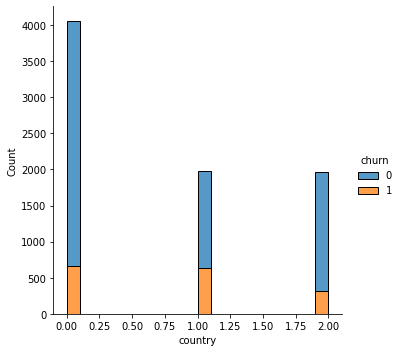

In [17]:
### STACKED HISTOGRAMS ###

load_data()

X_train_clean = pipe_clean.fit_transform(X_train)
X_train_clean.drop(["row_number", "customer_id"], axis=1, inplace=True) #.hist(figsize=(15, 15))
# X_train_clean.hist(figsize=(15, 15))
X_train_clean["sex"] = X_train_clean["sex"].astype('category').cat.codes
X_train_clean["country"] = X_train_clean["country"].astype('category').cat.codes
X_train_clean["churn"] = y["churn"]

hist_features = ["tenure", "account_balance", "number_of_products", "has_health_insurance",
            "has_life_insurance", "salary_estimated", "monthly_fees", "sex", "country"]
for col in hist_features:
    sns.displot(data=X_train_clean, x=col, hue="churn", multiple="stack")

churn_ratio = y["churn"].sum() / len(df.index)
print("churn_ratio:", churn_ratio)


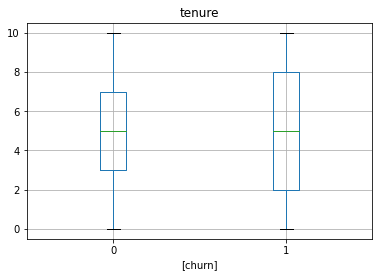

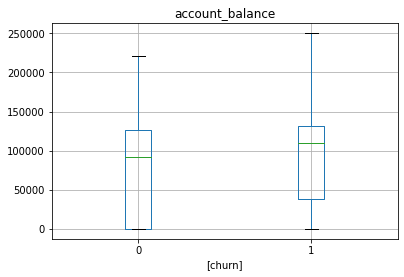

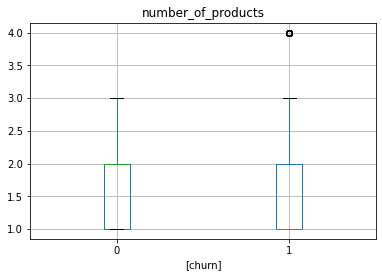

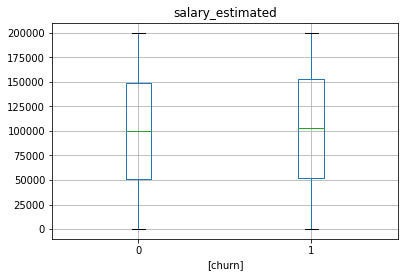

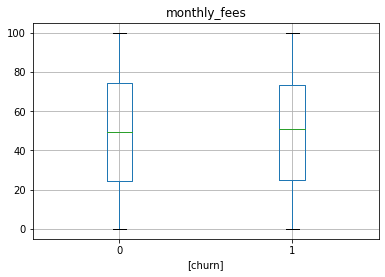

In [48]:
### GROUPED BOXPLOTS ###

#X_clean[["tenure", "account_balance", "number_of_products", 
#         "salary_estimated", "monthly_fees", "age", "credit_score"]
#       ].plot(kind="box",subplots=True,figsize=(20,10),title="Data with Outliers");

X_clean_y = X_clean.copy()
X_clean_y["churn"] = y["churn"]

for cn in ["tenure", "account_balance", "number_of_products", 
         "salary_estimated", "monthly_fees"]:
    axes = X_clean_y.boxplot(column=[cn], by=['churn'])
    plt.suptitle('')
    plt.show()

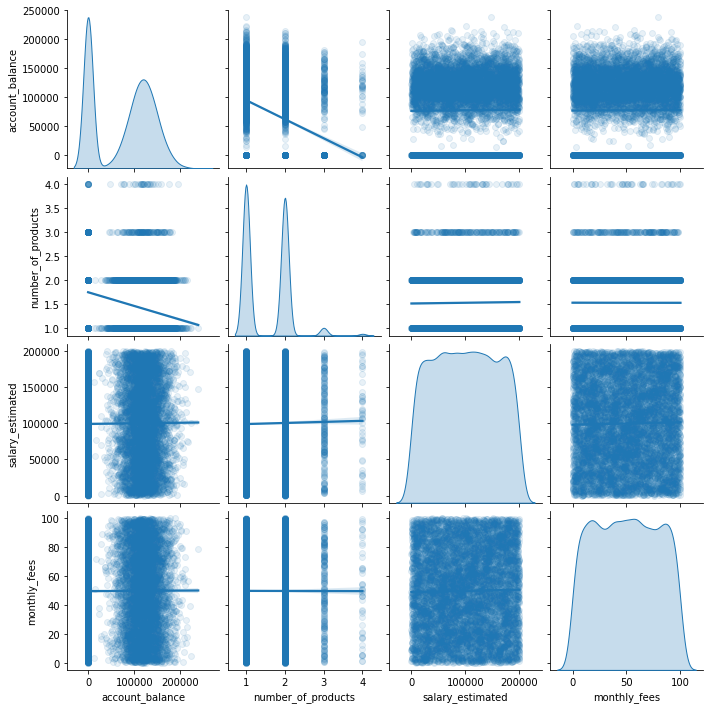

In [113]:
### Pairplot of clean data to see if there is some correlation between features ###
_ = sns.pairplot(
    X_train_clean[['account_balance', 'number_of_products', 'salary_estimated', 'monthly_fees']],
    kind='reg', diag_kind='kde', plot_kws={'scatter_kws': {'alpha': 0.1}})

### 5. Prepare Classifiers for GridSearch 

In [11]:
display(pipe_all)

Pipeline(steps=[('clean',
                 Pipeline(steps=[('clean_salary_estimated',
                                  SalaryEstimatedTransformer()),
                                 ('clean_monthly_fees',
                                  MonthlyFeesTransformer()),
                                 ('clean_credit_score_transformer',
                                  CreditScoreTransformer()),
                                 ('clean_has_health_insurance',
                                  HasHealthInsuranceTransformer()),
                                 ('add_age_transformer', AgeTransformer()),
                                 ('drop',
                                  ColumnDropperTransformer(columns=...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['country', 'sex']),
                                                 ('binary',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant'))]),
                                                  ['has_health_insurance',
                                                   'has_life_insurance'])])),
                ('select_features',
                 SelectKBest(k=5,
                             score_func=<function mutual_info_classif at 0x132268c10>)),
                ('classify', SVC())])

In [7]:
# to see param names for construction of classifier pipelines in next step
pipe_process.get_params(deep=True)

{'memory': None,
 'steps': [('preprocess',
   ColumnTransformer(transformers=[('numeric',
                                    Pipeline(steps=[('imputer', SimpleImputer()),
                                                    ('scaler', StandardScaler())]),
                                    ['account_balance', 'number_of_products',
                                     'salary_estimated', 'monthly_fees',
                                     'tenure']),
                                   ('categorical',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('onehot',
                                                     OneHotEncoder(handle_unknown='ignore'))]),
                                    ['country', 'sex']),
                                   ('binary',
                                    Pipeline(steps=[('imputer',
        

In [8]:
### ASSEMBLE CLASSIFIERS AND PARAMS FOR GRIDSEARCH ###

class_weights = [{1: 1, 0: 0.2}, {1: 1, 0: 0.3}, {1: 1, 0: 0.4}]
select_features_k = [3, 5, 7, 9, 11]

clf_rf = RandomForestClassifier(random_state=42)
clf_svc = SVC(probability=True, random_state=42)
clf_knn = KNeighborsClassifier()
clf_ada = AdaBoostClassifier()
clf_gb = GradientBoostingClassifier(random_state=42)
clf_nb = MultinomialNB()

param_rf = {}
param_rf['select_features__k'] = select_features_k
param_rf['classify__n_estimators'] = [50, 100, 250, 500]
param_rf['classify__max_depth'] = [5, 10, 15]
param_rf['classify__class_weight'] = class_weights
param_rf['classify'] = [clf_rf]

param_svc = {}
param_svc['select_features__k'] = select_features_k
param_svc['classify__C'] = [10**-2, 10**-1, 10**0]
param_svc['classify__class_weight'] = class_weights
param_svc['classify'] = [clf_svc]

param_knn = {}
param_knn['select_features__k'] = select_features_k
param_knn['classify__n_neighbors'] = [2,5,10,25,50]
param_knn['classify'] = [clf_knn]

param_ada = {}
param_ada['select_features__k'] = select_features_k
param_ada['classify__n_estimators'] = [10, 50, 250, 500]
param_ada['classify__learning_rate'] = [0.01, 0.1, 1]
param_ada['classify'] = [clf_ada]

param_gb = {}
param_gb['select_features__k'] = select_features_k
param_gb['classify__n_estimators'] = [10, 50, 100, 250]
param_gb['classify__max_depth'] = [5, 10, 20]
param_gb['classify'] = [clf_gb]

param_nb = {}
param_nb['select_features__k'] = select_features_k
param_nb['classify__alpha'] = [10**0, 10**1, 10**2]
param_nb['classify'] = [clf_nb]

#params = [param_rf, param_svc, param_knn, param_ada, param_gb, param_nb]
params = [param_svc]

### 6. Run GridSearch

In [88]:
%%time
### RUN GRIDSEARCH ###

load_data()
X_train_clean = pipe_clean.fit_transform(X_train)  # extra out-of-pipeline step to not repeat in GridSearch

custom_scoring = {"accuracy": "accuracy", "precision": make_scorer(precision_score, zero_division=0),
                  "recall": "recall", "f1": "f1"}

refit = "f1"

grid = GridSearchCV(estimator=pipe_process,
                   param_grid=params,
                   scoring=custom_scoring,
                   refit=refit,
                   cv=5,
                   n_jobs=-1)

grid.fit(X_train_clean, y_train["churn"])
print(f"Best parameters ({refit}={grid.best_score_}):", grid.best_params_)
print("----------")

res_df = pd.DataFrame(grid.cv_results_)

time_str = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
params_str = get_filename_from_params(params)
res_df.to_pickle(f"./gridsearch_results/{time_str}_{params_str}")

filter_gridsearch_result(res_df)

Data loaded
Best parameters (f1=0.5268447270279214): {'classify': SVC(C=1, class_weight={0: 0.3, 1: 1}, probability=True, random_state=42), 'classify__C': 1, 'classify__class_weight': {1: 1, 0: 0.3}, 'select_features__k': 11}
----------
CPU times: user 13.6 s, sys: 387 ms, total: 14 s
Wall time: 6min 1s


,param_classify,param_classify__C,param_classify__class_weight,param_select_features__k,params,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1
0,"SVC(C=1, class_weight={0: 0.3, 1: 1}, probabil...",0.01,"{1: 1, 0: 0.2}",3,"{'classify': SVC(C=1, class_weight={0: 0.3, 1:...",0.568625,0.302790,0.846273,0.444785
1,"SVC(C=1, class_weight={0: 0.3, 1: 1}, probabil...",0.01,"{1: 1, 0: 0.2}",5,"{'classify': SVC(C=1, class_weight={0: 0.3, 1:...",0.488375,0.274326,0.917623,0.421969
2,"SVC(C=1, class_weight={0: 0.3, 1: 1}, probabil...",0.01,"{1: 1, 0: 0.2}",7,"{'classify': SVC(C=1, class_weight={0: 0.3, 1:...",0.393125,0.247906,0.953252,0.392199
3,"SVC(C=1, class_weight={0: 0.3, 1: 1}, probabil...",0.01,"{1: 1, 0: 0.2}",9,"{'classify': SVC(C=1, class_weight={0: 0.3, 1:...",0.276250,0.218782,0.992617,0.358421
4,"SVC(C=1, class_weight={0: 0.3, 1: 1}, probabil...",0.01,"{1: 1, 0: 0.2}",11,"{'classify': SVC(C=1, class_weight={0: 0.3, 1:...",0.209625,0.204554,1.000000,0.339635
5,"SVC(C=1, class_weight={0: 0.3, 1: 1}, probabil...",0.01,"{1: 1, 0: 0.3}",3,"{'classify': SVC(C=1, class_weight={0: 0.3, 1:...",0.677000,0.368870,0.750360,0.489027
6,"SVC(C=1, class_weight={0: 0.3, 1: 1}, probabil...",0.01,"{1: 1, 0: 0.3}",5,"{'classify': SVC(C=1, class_weight={0: 0.3, 1:...",0.712250,0.387360,0.707898,0.499973
7,"SVC(C=1, class_weight={0: 0.3, 1: 1}, probabil...",0.01,"{1: 1, 0: 0.3}",7,"{'classify': SVC(C=1, class_weight={0: 0.3, 1:...",0.763500,0.430336,0.464310,0.440934
8,"SVC(C=1, class_weight={0: 0.3, 1: 1}, probabil...",0.01,"{1: 1, 0: 0.3}",9,"{'classify': SVC(C=1, class_weight={0: 0.3, 1:...",0.797250,0.533067,0.180797,0.254626
9,"SVC(C=1, class_weight={0: 0.3, 1: 1}, probabil...",0.01,"{1: 1, 0: 0.3}",11,"{'classify': SVC(C=1, class_weight={0: 0.3, 1:...",0.799750,0.576638,0.056597,0.102469


### 7. Evaluate Best Model

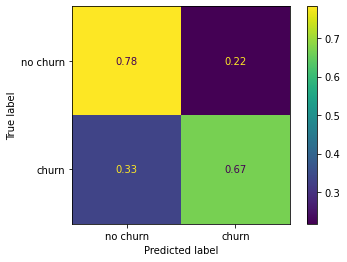

0.7585 0.6713300607760636 0.6666666666666666 0.44193548387096776 0.5315227934044616


In [89]:
### SCORES AND CONFUSION MATRIX OF BEST MODEL ###

X_validate_clean = pipe_clean.fit_transform(X_validate)  # step is plit because GridSearch pipeline acts on clean data
y_pred = grid.best_estimator_.predict(X_validate_clean)
cfm = confusion_matrix(y_validate, y_pred, normalize="true")
#disp = ConfusionMatrixDisplay(confusion_matrix=cfm, display_labels=grid.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cfm, display_labels=["no churn", "churn"])
disp.plot()
plt.show()

acc = accuracy_score(y_pred, y_validate)
balacc = balanced_accuracy_score(y_pred, y_validate)
prec = precision_score(y_pred, y_validate)
rec = recall_score(y_pred, y_validate)
f1 = f1_score(y_pred, y_validate)
print(acc, balacc, prec, rec, f1)

### 8. Model Explainability

In [91]:
### MUTUAL INFORMATION / INFORMATION GAIN OF FEATURES ###

kbest_mutinf = SelectKBest(mutual_info_classif, k=12)

kbest_mutinf.fit(X_prepro_df, y["churn"])

mutual_information = dict(zip(kbest_mutinf.get_feature_names_out(), kbest_mutinf.scores_))
mutual_information_sorted = dict(sorted(mutual_information.items(), key=lambda item: item[1], reverse=True))
mutual_information_sorted

{'numeric__number_of_products': 0.0729416908503655,
 'categorical__country_Germany': 0.013342927188751075,
 'binary__has_life_insurance': 0.010402150486518158,
 'numeric__account_balance': 0.0077969756853539796,
 'categorical__sex_Female': 0.0060166461242694425,
 'categorical__sex_Male': 0.005949725156090269,
 'categorical__country_France': 0.005772312932351031,
 'numeric__salary_estimated': 0.00275131392713468,
 'categorical__country_Spain': 0.001823154230270907,
 'numeric__monthly_fees': 0.001605709655498666,
 'numeric__tenure': 0.0,
 'binary__has_health_insurance': 0.0}

In [108]:
### PERMUTATION IMPORTANCE OF FEATURES ###

X_validate_clean = pipe_clean.fit_transform(X_validate);
#X_validate_prepro = pipe_prepro.fit_transform(X_validate);

perm_importance = permutation_importance(grid.best_estimator_, X_validate_clean, y_validate)

perm_importance

{'importances_mean': array([ 0.0299,  0.0034, -0.0028,  0.0472,  0.1649, -0.0028,  0.0085,
        -0.0033,  0.    ]),
 'importances_std': array([0.00391663, 0.0012    , 0.00180555, 0.00896995, 0.00909065,
        0.0005099 , 0.00316228, 0.00231517, 0.        ]),
 'importances': array([[ 0.0285,  0.023 ,  0.0335,  0.0335,  0.031 ],
        [ 0.002 ,  0.005 ,  0.002 ,  0.004 ,  0.004 ],
        [-0.002 , -0.0045, -0.005 ,  0.    , -0.0025],
        [ 0.0545,  0.061 ,  0.04  ,  0.0425,  0.038 ],
        [ 0.168 ,  0.1795,  0.158 ,  0.153 ,  0.166 ],
        [-0.0035, -0.002 , -0.003 , -0.003 , -0.0025],
        [ 0.007 ,  0.0075,  0.004 ,  0.013 ,  0.011 ],
        [ 0.    , -0.0055, -0.005 , -0.005 , -0.001 ],
        [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ]])}

Text(0.5, 0, 'Permutation Importance')

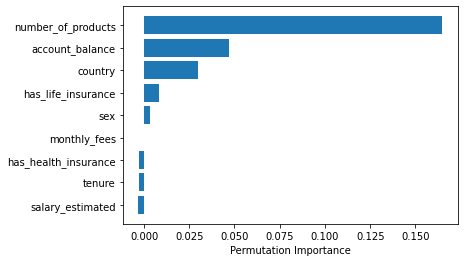

In [112]:
feature_names = X_validate_clean.columns
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>

### DataFrameMapper approach for preprocessed named features in DataFrame instead of numpy array
(Because certain parts scikit learn pipelines just dont work well with named features and DataFrames as they are passed as pure numpy arrays between the steps. In the end I wrote some custom Transformers to maintain column names in between steps)

In [10]:
from sklearn_pandas import DataFrameMapper, gen_features

In [56]:
### DataFrameMapper PLAYGROUND ###

numeric_features = ['account_balance', 'number_of_products', 'salary_estimated', 'monthly_fees', 'tenure', 'credit_score']
binary_features = [ 'has_health_insurance','has_life_insurance']
categorical_features = [ 'country', 'sex' ]

pipe_clean = Pipeline(steps= [
    ("clean_salary_estimated", SalaryEstimatedTransformer()),
    ("clean_monthly_fees", MonthlyFeesTransformer()),
    ("clean_credit_score_transformer", CreditScoreTransformer()),
    ("clean_has_health_insurance", HasHealthInsuranceTransformer()),
    ("add_age_transformer", AgeTransformer()),
], verbose=pipeline_verbose)

X_clean = pipe_clean.fit_transform(X)

num_feature_gen = gen_features(
    columns=[[fn] for fn in numeric_features],
    classes=[
        {'class': SimpleImputer,'strategy':'median'},
        {'class': StandardScaler}
    ]
)

bin_feature_gen = gen_features(
    columns=[[fn] for fn in binary_features],
    classes=[
        {'class': SimpleImputer, 'strategy': 'constant', 'fill_value': 0}
    ]
)

cat_feature_gen = gen_features(
    #columns=[[[fn]] for fn in categorical_features],
    columns=['sex'],
    classes=[
        {'class': SimpleImputer, 'strategy': 'constant', 'fill_value': 0},
        {'class': OneHotEncoder, 'handle_unknown': 'ignore'}
    ]
)

categorical_dfms = [DataFrameMapper([
    ([[fn]], [SimpleImputer(strategy='most_frequent'), OneHotEncoder()])
], df_out=True, default=None) for fn in categorical_features]


#mp = make_pipeline(
#    DataFrameMapper(num_feature_gen, input_df=True, df_out=True, default=None),
#    DataFrameMapper(bin_feature_gen, input_df=True, df_out=True, default=None),
#)

u = PandasFeatureUnion.make_union_pandas(*categorical_dfms,
                                        DataFrameMapper(bin_feature_gen, input_df=True, df_out=True, default=None),
                                        DataFrameMapper(cat_feature_gen, input_df=True, df_out=True, default=None)
                                        )


p = Pipeline(steps= [
    #("clean", pipe_clean),
    ('preprocess', categorical_dfms[0]),
#    ('classify', classifier)
], verbose=pipeline_verbose)


#f = categorical_dfms[0].fit_transform(X_clean)  # works if called like this
f = p.fit_transform(X_clean)  # does not
f


#mapper = DataFrameMapper([
#    ('sex', [SimpleImputer(fill_value=0, strategy='constant'), OneHotEncoder()])
#], df_out=True)

#fdsa = u.fit_transform(asdf)
#fdsa

KeyError: "None of [Index([('country',)], dtype='object')] are in the [columns]"